In [9]:
# make the fortran module using f2py if you haven't already
# f2py -c -m bottCC coad1dpy.f 

import bottCC as bcc # import the collision coalescence module

# set parameters 
# rq0 is the radius mode in microns
# xmw is the total water content in g/m3
# nbins is the number of bins (this is hard coded in the fortran code to be 400)
# dt is the time step in seconds 
rq0_in=10.
xmw_in=1.0
nbins=400
dt=1.0
g_out,r_out,dlnr_out = bcc.coad1d_init(rq0_in,xmw_in,nbins,dt)  # this initializes the arrays and sets the initial mass distribution
# r_out is the range of radii in microns
# g_out is the initial mass distribution in g/m3/ln(r) 
# g_out.sum()*dlnr_out is the total water content
# while subroutine coad1d_init analytically sets the initial mass distribution, 
# one can set the initial mass distribution to any distribution they want and 
# reset the initial mass distribution using subroutine set_g_initial
t=0.0
g_out=2*g_out
bcc.set_g_initial(g_out) # this resets the initial mass distribution to 2 times the initial mass distribution

while t<3600:
    g,t = bcc.integrate(nbins,dt,t)


 parametros y condiciones iniciales
   1.0000000000000000        9.9999997473787516E-004   1.0000000000000000E-003   4.1887901287325355E-006   238.73241897239308        6.0000000000000000                1


(1e-11, 0.01)

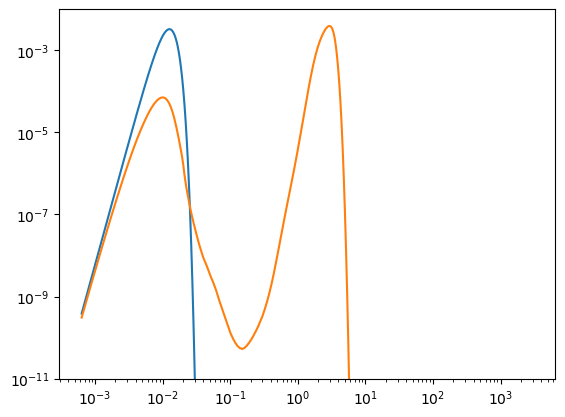

In [10]:

import matplotlib.pyplot as plt

plt.plot(r_out[:400]*1e-3,g_out[:400])
plt.xscale('log')
plt.yscale('log')

plt.plot(r_out[:400]*1e-3,g[:400])
plt.ylim(1e-11,1e-2) 


In [12]:
print(g.sum()*dlnr_out)
print(g_out.sum()*dlnr_out)

0.00199999999945355
0.0019999998559994125
